In [4]:
import scipy
import sympy
import numpy as np
import matplotlib.patches
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation

MovieWriter ffmpeg unavailable; using Pillow instead.


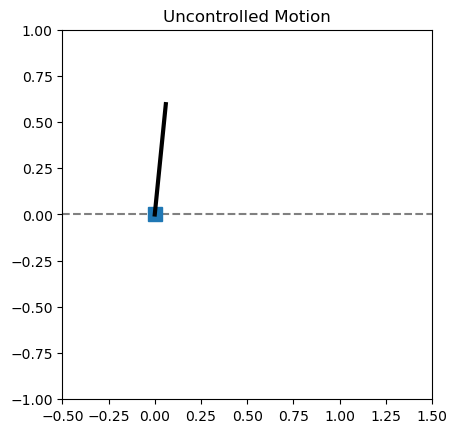

In [5]:
# Parameters
M = 2.4
m = 0.23
c = 0.05
l = 0.3
I = 0.099
g = 9.81

# Dynamic equations - nonlinear
def nonlinear_dynamics(state, u):
    _, theta, xdot, thetadot = state

    alpha = M + m - m**2 * l**2 * np.cos(theta)**2 / (m * l**2 + I)
    beta = m * l**2 + I - m**2 * l**2 * np.cos(theta)**2 / (M + m)
    
    xddot_alpha = u(state) - c * xdot + m**2 * l**2 * g * np.sin(theta) * np.cos(theta) / (m * l**2 + I) + m * l * thetadot**2 * np.sin(theta)
    thetaddot_beta = m * g * l * np.sin(theta) - m * l * np.cos(theta) / (M + m) * ( u(state) - c * xdot + m * l * thetadot**2 * np.sin(theta) )
    statedot = np.array([ xdot, thetadot, xddot_alpha/alpha, thetaddot_beta/beta ])
    return statedot

# Simulate nonlinear dynamics
X0 = np.array([ 0, .1, .1, 0 ])
sol = scipy.integrate.solve_ivp(
    lambda t, y: nonlinear_dynamics(y, lambda x:0), 
    t_span=(0, 10), 
    y0=X0, 
    max_step=1e-2
)

# Animate the solution
length = l * 2
dt = sol.t[1] - sol.t[0]

def update_plot(i):
    plt.cla()
    ax.set_xlim(-.5, 1.5)
    ax.set_ylim(-1, 1)

    # Calculate positions
    index = i * 10
    if index >= len(sol.y.T):
        return
    
    x, theta, _, _ = sol.y.T[index]
    pend_x = x + np.sin(theta) * length
    pend_y = np.cos(theta) * length

    # Plot ground
    ax.plot([-.5, 1.5], [0, 0], color="gray", linestyle="dashed")
    
    # Plot cart
    ax.plot(x, 0, marker="s", markersize=10)

    # Plot pendulum
    ax.plot([x, pend_x], [0, pend_y], color="black", linewidth=3)
    ax.set_aspect("equal")
    ax.set_title("Uncontrolled Motion")

fig, ax = plt.subplots()
anim = FuncAnimation(fig, update_plot, frames=len(sol.t)//10, interval=dt*1000*10)
anim.save("unforced.gif")

MovieWriter ffmpeg unavailable; using Pillow instead.


System is Controllable: True


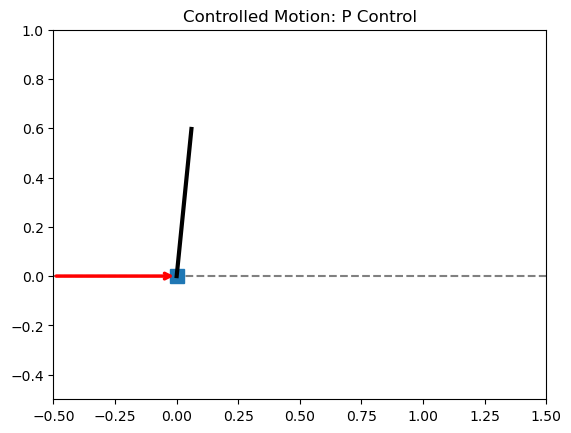

In [6]:
# Linearize the system such that dx/dt = Ax + Bu
alpha = 1 / ( M + m - m**2 * l**2 / (m * l**2 + I) )
beta = 1 / (m * l**2 + I - m**2 * l**2 / (M + m))

A = np.array([
    # x  theta          dx/dt               dtheta/dt
    [ 0, 0,             1,                  0 ],
    [ 0, 0,             0,                  1 ],
    [ 0, alpha*m**2*l**2*g/(m*l**2 + I),   -alpha*c,  0 ],
    [ 0, beta*m*g*l,    beta*m*l*c/(M+m),   0 ]
])
B = np.array([
    [0],
    [0],
    [alpha],
    [-beta*m*l/(M+m)],
])

# Check for controllability
ctrb = np.hstack([
    B,
    A @ B,
    np.linalg.matrix_power(A, 2) @ B,
    np.linalg.matrix_power(A, 3) @ B
])
controllable = np.linalg.matrix_rank(ctrb) == 4
print(f"System is Controllable: {controllable}")

# Place poles
poles = np.array([-1, -1.1, -1.2, -1.3])
full_state_feedback = scipy.signal.place_poles(A, B, poles)
K = full_state_feedback.gain_matrix

# Define control law
reference_x        = 0
reference_theta    = 0
reference_dxdt     = 0
reference_dthetadt = 0
def u(state):
    x, theta, xdot, thetadot = state
    return -(
        K[0, 0] * (x - reference_x)
        + K[0, 1] * (theta - reference_theta) 
        + K[0, 2] * (xdot - reference_dxdt) 
        + K[0, 3] * (thetadot - reference_dthetadt)
    )

# Simulate new system
sol = scipy.integrate.solve_ivp(
    lambda t, y: nonlinear_dynamics(y, u), 
    t_span=(0, 10), 
    y0=X0, 
    max_step=1e-2
)

all_u = [u(sol.y.T[idx]) for idx in range(len(sol.t))]
max_u = max(all_u)
def update_plot(i):
    plt.cla()

    # Calculate positions
    index = i * 10
    if index >= len(sol.y.T):
        return
    
    x, theta, _, _ = sol.y.T[index]
    pend_x = x + np.sin(theta) * length
    pend_y = np.cos(theta) * length

    leftx = -.5
    rightx = 1.5
    # leftx = x - .5
    # rightx = x + 1
    ax.set_xlim(leftx, rightx)
    ax.set_ylim(-.5, 1)

    # Plot ground
    ax.plot([leftx, rightx], [0, 0], color="gray", linestyle="dashed")
    
    # Plot cart
    ax.plot(x, 0, marker="s", markersize=10)

    # Plot pendulum
    ax.plot([x, pend_x], [0, pend_y], color="black", linewidth=3)
    ax.set_aspect("equal")
    ax.set_title("Controlled Motion: P Control")

    # Plot force arrow
    fl = (all_u[index] / max_u) * .5
    if fl > 0:
        plt.annotate("", xy=[x, 0], xycoords="data", xytext=[x - fl, 0], arrowprops=dict(arrowstyle='->',color='red',lw=2.5))
    else:
        plt.annotate("", xy=[x + fl, 0], xycoords="data", xytext=[x, 0], arrowprops=dict(arrowstyle='->',color='red',lw=2.5))

fig, ax = plt.subplots()
anim = FuncAnimation(fig, update_plot, frames=len(sol.t)//10, interval=dt*1000*10)
anim.save("forced.gif")